# BIG CHALLENGE/DILEMMA

Twee opties:
1. We lezen de .net-bestanden (1 per sliding window) los in en runnen voor elk bestand een losse *graph partitioning* analyse
2. We voegen het eerst samen tot één graaf en doen slechts één analyse

voordelen 1:
- geen 'ketenen': het kan niet gebeuren dat een gebeurtenis uiteindelijk meerdere weken omvat, omdat er telkens weer een bruggetje is wat een cluster aansluit op het volgende

nadelen 1:
- een artikel kan bij meerdere events horen (laatste dag van een bestand = middenste dag van het volgende bestand); deze overlap is niet gewenst


--> het lijkt erop dat de bizar lange ketens (duizenden artikelen) vermeden kunnen worden door Surprise ipv Modularity te berekenen. "In short, surprise works well in the limit of many small communities, whereas modularity works better in the limit of few large communities."  (https://journals.aps.org/pre/abstract/10.1103/PhysRevE.92.022816)


--> OPGELOST!!! (denk ik) 
- optie 2
- maar dan met Surprise
- en zeer hoge drempel (minedgeweight = .6 of zo)

# TODO: softcosine en cosine systematisch vergelijken

# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [121]:
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [122]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [123]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. We therefore do 
# *not* do this in the final paper:

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')



100%|██████████| 149/149 [00:42<00:00,  3.11it/s]

45608 nodes and 935592 edges
Removing self loops...
45608 nodes and 890597 edges



  1%|▏         | 2/149 [00:00<00:10, 13.37it/s]

All written to ../../data/intermediate/softcosine_merged.net



100%|██████████| 149/149 [00:09<00:00, 18.33it/s]

45213 nodes and 109336 edges
Removing self loops...
45213 nodes and 64341 edges
All written to ../../data/intermediate/cosine_merged.net


In [124]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [125]:
def partition_graph(G, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G.es.select(weight_le=minedgeweight).delete()
    # part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [126]:
# this may be buggy. I believe we need to FIRST merge the graphs, then do the partitioing,
# because otherwise the same article can end up in multiple events

def analyze_files_BAD(files, minedgeweight=.2):
    '''Reads a list of graph files, passes them to partition_graph(), and concatenats the results'''
    G = ig.Graph()
    results = []
    for f in tqdm(files):
        Gi = ig.read(f, format='pajek')
        try:
            results.extend(partition_graph(Gi, minedgeweight))
        except Exception as e:
            print('Error while trying to process edge weights in file {}'.format(f))
            print(e)
    return results

In [172]:
def show_descriptives(results):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

In [128]:
def print_gridreport(gridresults):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]

        print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple events)')
    print('\n\n')

    for r in gridresults:
        print("*"*80)
        print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
        print("*"*80)
        show_descriptives(r['results'])
        print('\n\n\n')

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4)

### Option 1: Losse bestanden

In [129]:
op1_grid = [('cos', cosinefiles, .2),
        ('cos', cosinefiles, .3),
        ('cos', cosinefiles, .4),
        ('cos', cosinefiles, .6),
        ('softcos', softcosinefiles, .2),
        ('softcos', softcosinefiles, .3),
        ('softcos', softcosinefiles, .4),
        ('softcos', softcosinefiles, .6)]

op1_gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': analyze_files_BAD(files, minedgeweight)} 
              for similarity, files, minedgeweight in op1_grid]




  3%|▎         | 4/149 [00:00<00:04, 35.59it/s]


100%|██████████| 149/149 [00:04<00:00, 30.07it/s]

Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


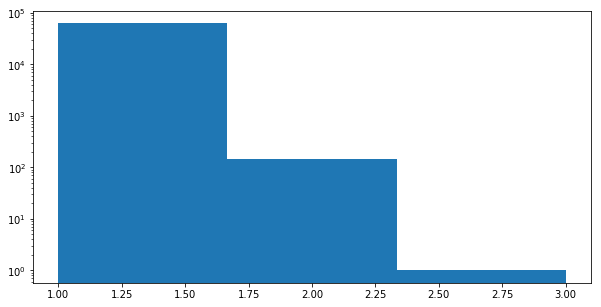

count    62806.000000
mean         1.002356
std          0.048814
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
dtype: float64
There are 62659 single-article events




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


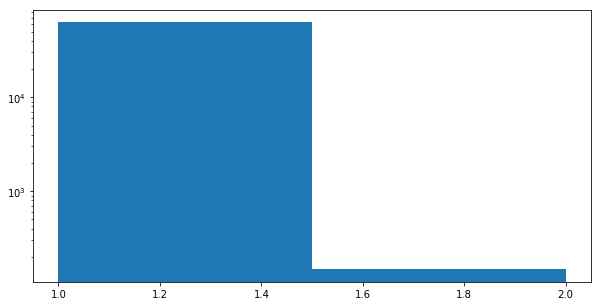

count    62807.000000
mean         1.002341
std          0.048322
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
dtype: float64
There are 62660 single-article events




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


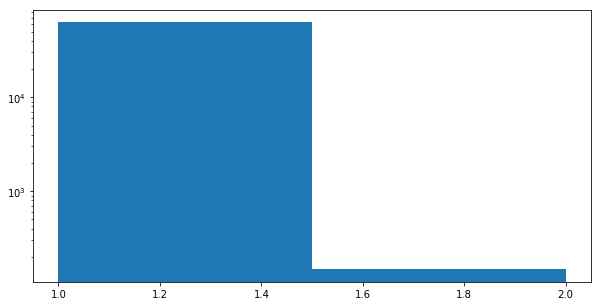

count    62807.000000
mean         1.002341
std          0.048322
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
dtype: float64
There are 62660 single-article events




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


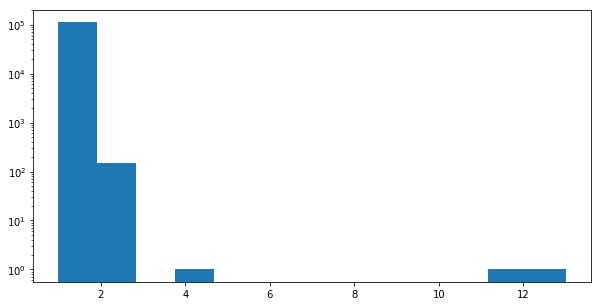

count    111655.000000
mean          1.001549
std           0.061385
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
dtype: float64
There are 111505 single-article events




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


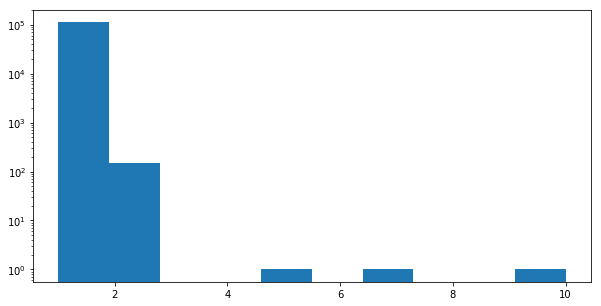

count    111660.000000
mean          1.001505
std           0.050232
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
dtype: float64
There are 111508 single-article events




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


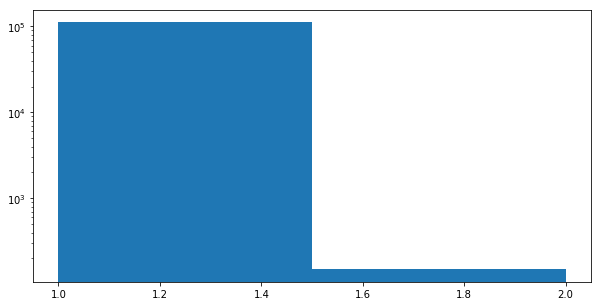

count    111679.000000
mean          1.001334
std           0.036502
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
dtype: float64
There are 111530 single-article events






In [169]:
print_gridreport(op1_gridresults)

### Option 2: Een graaf

In [149]:

op2_grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('cos', Gcos, .6),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .6)]

op2_gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in op2_grid]



Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


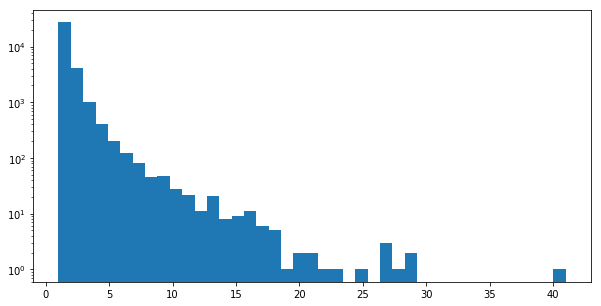

count    33378.000000
mean         1.354575
std          1.210586
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27133 single-article events and 6245 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


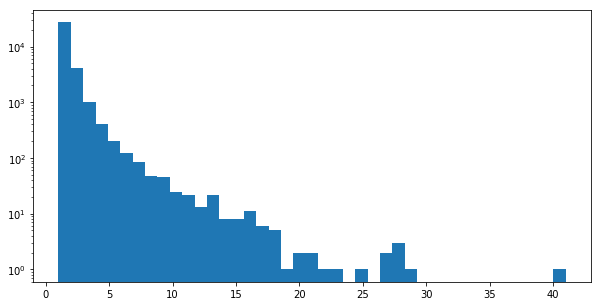

count    33379.000000
mean         1.354534
std          1.210318
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27137 single-article events and 6242 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


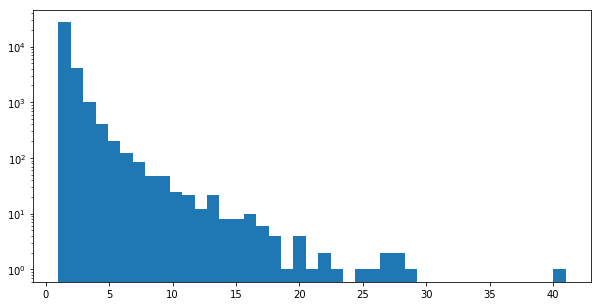

count    33377.000000
mean         1.354615
std          1.211546
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27135 single-article events and 6242 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


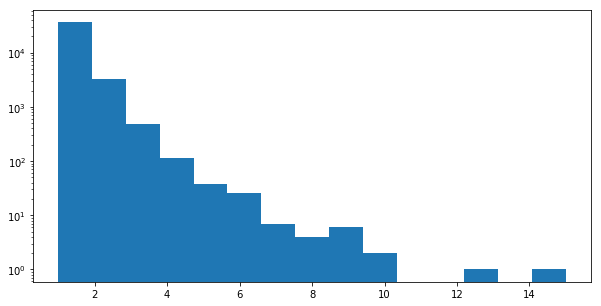

count    40247.000000
mean         1.123388
std          0.449985
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36348 single-article events and 3899 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


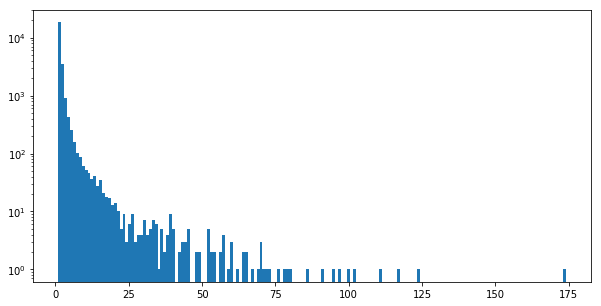

count    24270.000000
mean         1.879192
std          4.330917
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        174.000000
dtype: float64

There are 18312 single-article events and 5958 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


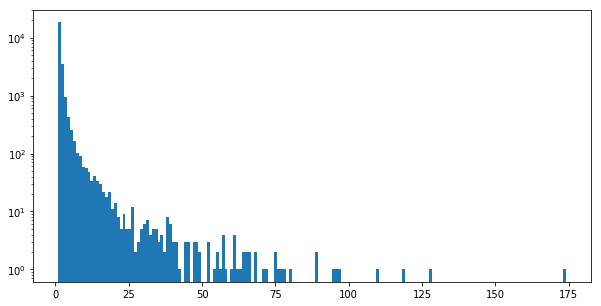

count    24276.000000
mean         1.878728
std          4.293616
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        174.000000
dtype: float64

There are 18308 single-article events and 5968 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


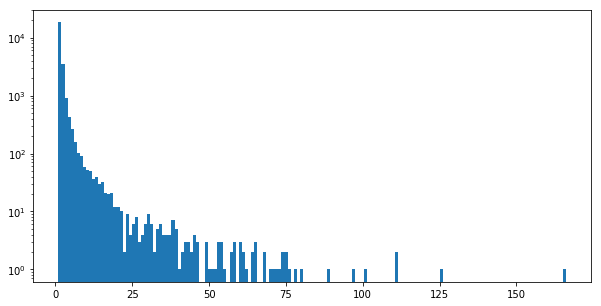

count    24290.000000
mean         1.877645
std          4.259523
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        166.000000
dtype: float64

There are 18316 single-article events and 5974 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


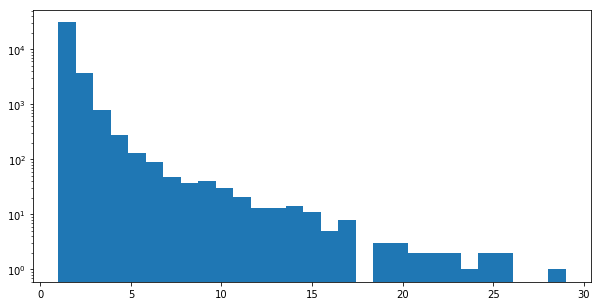

count    35958.000000
mean         1.268369
std          1.071417
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         29.000000
dtype: float64

There are 30701 single-article events and 5257 multiple-article events.






In [173]:
print_gridreport(op2_gridresults)

In [133]:
# gridresults[4]['results'][3]

## Evaluation of the results

check how much sense it makes etc

In [151]:
df = pd.DataFrame(op2_gridresults[-1]['results'])
df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,https://www.nu.nl/-/5856270/,ec8ead0,https://www.nu.nl/-/5855889/,https://www.nu.nl/-/5855625/,https://www.ad.nl/buitenland/dodental-aanslage...,https://www.ad.nl/buitenland/aanslagen-sri-lan...,https://www.nu.nl/-/5856792/,https://www.nu.nl/-/5856861/,https://www.nu.nl/-/5858103/,https://www.nu.nl/-/5858202/,...,https://www.nu.nl/-/5855100/,https://www.nu.nl/-/5854425/,https://www.nu.nl/-/5855136/,b544c0f7,https://www.nu.nl/-/5860734/,https://www.nu.nl/-/5861880/,https://www.ad.nl/buitenland/vuurgevecht-met-v...,https://www.nu.nl/-/5863722/,https://www.nu.nl/-/5862495/,https://www.nu.nl/-/5863329/
1,https://www.nu.nl/-/5717091/,https://www.nu.nl/-/5715381/,https://www.ad.nl/binnenland/het-gaat-weer-sne...,https://www.nu.nl/-/5715474/,https://www.ad.nl/binnenland/minder-treinen-do...,https://www.ad.nl/binnenland/sneeuwfront-trekt...,https://www.nu.nl/-/5717541/,https://www.nu.nl/-/5717514/,4cc0a4a,https://www.ad.nl/binnenland/zo-ziet-zaterdag-...,...,https://www.nu.nl/-/5712684/,https://www.ad.nl/binnenland/files-en-winterpr...,https://www.ad.nl/buitenland/minder-treinen-do...,https://www.nu.nl/-/5713263/,https://www.nu.nl/-/5714388/,https://www.nu.nl/-/5715228/,https://www.nu.nl/-/5713218/,None,None,None
2,1f5b6c7,1c8c51c,6a66a47,945d4cd2,bd955ba,df04e3b,1edde55,https://www.nu.nl/-/5801676/,https://www.nu.nl/-/5801733/,https://www.nu.nl/-/5802180/,...,https://www.nu.nl/-/5797839/,https://www.ad.nl/politiek/partijen-vechten-vo...,9076b08,https://www.nu.nl/-/5801637/,https://www.nu.nl/-/5801442/,https://www.nu.nl/-/5801613/,https://www.nu.nl/-/5801625/,None,None,None
3,https://www.ad.nl/buitenlands-voetbal/spurs-ze...,https://www.ad.nl/buitenlands-voetbal/aubameya...,https://www.nu.nl/-/5646515/,https://www.nu.nl/-/5648132/,https://www.ad.nl/buitenlands-voetbal/pochetti...,https://www.nu.nl/-/5649662/,https://www.ad.nl/buitenlands-voetbal/alexande...,https://www.nu.nl/-/5650313/,https://www.ad.nl/buitenlands-voetbal/liverpoo...,https://www.ad.nl/buitenlands-voetbal/manchest...,...,https://www.ad.nl/buitenlands-voetbal/guardiol...,https://www.ad.nl/buitenlands-voetbal/chelsea-...,https://www.ad.nl/buitenlands-voetbal/milner-m...,https://www.nu.nl/-/5656313/,https://www.ad.nl/buitenlands-voetbal/liverpoo...,https://www.nu.nl/-/5656598/,None,None,None,None
4,https://www.ad.nl/europees-voetbal/ajax-speelt...,https://www.ad.nl/nederlands-voetbal/duel-tuss...,https://www.nu.nl/-/5849259/,https://www.nu.nl/-/5847960/,https://www.ad.nl/nederlands-voetbal/knvb-wil-...,https://www.ad.nl/nederlands-voetbal/knvb-werk...,https://www.ad.nl/nederlands-voetbal/knvb-verp...,https://www.nu.nl/-/5851014/,0cb6a92,https://www.ad.nl/buitenlands-voetbal/ajax-tre...,...,https://www.ad.nl/nederlands-voetbal/laatste-s...,https://www.nu.nl/-/5858067/,https://www.nu.nl/-/5853690/,https://www.ad.nl/europees-voetbal/tottenham-k...,https://www.nu.nl/-/5853999/,https://www.nu.nl/-/5846022/,None,None,None,None
5,https://www.ad.nl/binnenland/giftig-poeder-uit...,https://www.ad.nl/binnenland/vlieland-stelt-re...,a7f2213,ad46aa7,https://www.nu.nl/-/5661839/,https://www.nu.nl/-/5663657/,https://www.ad.nl/binnenland/rederij-zoekt-met...,https://www.nu.nl/-/5662472/,https://www.ad.nl/politiek/strafrechtelijk-ond...,3182475,...,https://www.ad.nl/binnenland/storm-op-komst-ge...,https://www.ad.nl/binnenland/flinke-storm-op-k...,aa7cedf,https://www.nu.nl/-/5661530/,https://www.nu.nl/-/5660957/,None,None,None,None,None
6,https://www.nu.nl/-/5758533/,https://www.nu.nl/-/5759421/,https://www.nu.nl/-/5759247/,https://www.nu.nl/-/5759559/,https://www.nu.nl/-/5759436/,https://www.nu.nl/-/5759631/,https://www.nu.nl/-/5759772/,https://www.nu.nl/-/5761347/,https://www.nu.nl/-/5760321/,https://www.nu.nl/-/5762289/,...,https://www.nu.nl/-/5754735/,https://www.nu.nl/-/5750856/,https://www.ad.nl/nederlands-voetbal/emile-roe...,https://www.ad.nl/nederlands-voetbal/zo-bespee...,None,None,None,None,None,None
7,https://www.ad.nl/a

In [154]:
df['numberofarticles'] = df.apply(lambda x: sum(x.notna()), axis=1)

In [155]:
df.query('numberofarticles>10')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,numberofarticles
0,https://www.nu.nl/-/5856270/,ec8ead0,https://www.nu.nl/-/5855889/,https://www.nu.nl/-/5855625/,https://www.ad.nl/buitenland/dodental-aanslage...,https://www.ad.nl/buitenland/aanslagen-sri-lan...,https://www.nu.nl/-/5856792/,https://www.nu.nl/-/5856861/,https://www.nu.nl/-/5858103/,https://www.nu.nl/-/5858202/,...,https://www.nu.nl/-/5854425/,https://www.nu.nl/-/5855136/,b544c0f7,https://www.nu.nl/-/5860734/,https://www.nu.nl/-/5861880/,https://www.ad.nl/buitenland/vuurgevecht-met-v...,https://www.nu.nl/-/5863722/,https://www.nu.nl/-/5862495/,https://www.nu.nl/-/5863329/,30
1,https://www.nu.nl/-/5717091/,https://www.nu.nl/-/5715381/,https://www.ad.nl/binnenland/het-gaat-weer-sne...,https://www.nu.nl/-/5715474/,https://www.ad.nl/binnenland/minder-treinen-do...,https://www.ad.nl/binnenland/sneeuwfront-trekt...,https://www.nu.nl/-/5717541/,https://www.nu.nl/-/5717514/,4cc0a4a,https://www.ad.nl/binnenland/zo-ziet-zaterdag-...,...,https://www.ad.nl/binnenland/files-en-winterpr...,https://www.ad.nl/buitenland/minder-treinen-do...,https://www.nu.nl/-/5713263/,https://www.nu.nl/-/5714388/,https://www.nu.nl/-/5715228/,https://www.nu.nl/-/5713218/,None,None,None,27
2,1f5b6c7,1c8c51c,6a66a47,945d4cd2,bd955ba,df04e3b,1edde55,https://www.nu.nl/-/5801676/,https://www.nu.nl/-/5801733/,https://www.nu.nl/-/5802180/,...,https://www.ad.nl/politiek/partijen-vechten-vo...,9076b08,https://www.nu.nl/-/5801637/,https://www.nu.nl/-/5801442/,https://www.nu.nl/-/5801613/,https://www.nu.nl/-/5801625/,None,None,None,27
3,https://www.ad.nl/buitenlands-voetbal/spurs-ze...,https://www.ad.nl/buitenlands-voetbal/aubameya...,https://www.nu.nl/-/5646515/,https://www.nu.nl/-/5648132/,https://www.ad.nl/buitenlands-voetbal/pochetti...,https://www.nu.nl/-/5649662/,https://www.ad.nl/buitenlands-voetbal/alexande...,https://www.nu.nl/-/5650313/,https://www.ad.nl/buitenlands-voetbal/liverpoo...,https://www.ad.nl/buitenlands-voetbal/manchest...,...,https://www.ad.nl/buitenlands-voetbal/chelsea-...,https://www.ad.nl/buitenlands-voetbal/milner-m...,https://www.nu.nl/-/5656313/,https://www.ad.nl/buitenlands-voetbal/liverpoo...,https://www.nu.nl/-/5656598/,None,None,None,None,26
4,https://www.ad.nl/europees-voetbal/ajax-speelt...,https://www.ad.nl/nederlands-voetbal/duel-tuss...,https://www.nu.nl/-/5849259/,https://www.nu.nl/-/5847960/,https://www.ad.nl/nederlands-voetbal/knvb-wil-...,https://www.ad.nl/nederlands-voetbal/knvb-werk...,https://www.ad.nl/nederlands-voetbal/knvb-verp...,https://www.nu.nl/-/5851014/,0cb6a92,https://www.ad.nl/buitenlands-voetbal/ajax-tre...,...,https://www.nu.nl/-/5858067/,https://www.nu.nl/-/5853690/,https://www.ad.nl/europees-voetbal/tottenham-k...,https://www.nu.nl/-/5853999/,https://www.nu.nl/-/5846022/,None,None,None,None,26
5,https://www.ad.nl/binnenland/giftig-poeder-uit...,https://www.ad.nl/binnenland/vlieland-stelt-re...,a7f2213,ad46aa7,https://www.nu.nl/-/5661839/,https://www.nu.nl/-/5663657/,https://www.ad.nl/binnenland/rederij-zoekt-met...,https://www.nu.nl/-/5662472/,https://www.ad.nl/politiek/strafrechtelijk-ond...,3182475,...,https://www.ad.nl/binnenland/flinke-storm-op-k...,aa7cedf,https://www.nu.nl/-/5661530/,https://www.nu.nl/-/5660957/,None,None,None,None,None,25
6,https://www.nu.nl/-/5758533/,https://www.nu.nl/-/5759421/,https://www.nu.nl/-/5759247/,https://www.nu.nl/-/5759559/,https://www.nu.nl/-/5759436/,https://www.nu.nl/-/5759631/,https://www.nu.nl/-/5759772/,https://www.nu.nl/-/5761347/,https://www.nu.nl/-/5760321/,https://www.nu.nl/-/5762289/,...,https://www.nu.nl/-/5750856/,https://www.ad.nl/nederlands-voetbal/emile-roe...,https://www.ad.nl/nederlands-voetbal/zo-bespee...,None,None,None,None,None,None,24
7,https://www.ad.nl/ad-werkt/jolanda-verzorgt-ko...,https://www.ad.nl/ad-werkt/bn-er-stacey-rookhu...,https://www.ad.nl/show/vlaamse-the-voice-deeln...,https://www.nu.nl/-/5815656/,https://www.nu.nl/-/5815719/,https://www.nu.nl/-/5817249/,https://www.n

In [137]:
# articles.query('_id=="{}"'.format('https://www.ad.nl/binnenland/doodgeschoten-humeyra-16-wilde-vluchten-naar-turkije~a8e5014d/'))

In [156]:
def results_to_titles(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['title'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [157]:
softcosine_results_titles = results_to_titles(op2_gridresults[-1]['results'])


  1%|          | 426/35958 [00:18<17:08, 34.55it/s]


  4%|▍         | 1409/35958 [00:34<09:06, 63.19it/s]


  8%|▊         | 2958/35958 [00:50<05:17, 104.06it/s]


 13%|█▎        | 4511/35958 [01:06<05:22, 97.53it/s] 


 19%|█▉        | 6967/35958 [01:21<02:09, 223.17it/s]


 29%|██▉       | 10374/35958 [01:36<01:50, 231.18it/s]


 38%|███▊      | 13751/35958 [01:51<01:36, 230.58it/s]


 48%|████▊     | 17116/35958 [02:05<01:21, 231.85it/s]


 57%|█████▋    | 20382/35958 [02:20<01:12, 215.99it/s]


 66%|██████▌   | 23693/35958 [02:35<00:53, 227.17it/s]


 75%|███████▌  | 27027/35958 [02:49<00:38, 231.76it/s]


 84%|████████▍ | 30326/35958 [03:04<00:24, 231.92it/s]


 94%|█████████▎| 33705/35958 [03:19<00:09, 231.73it/s]


100%|██████████| 35958/35958 [03:30<00:00, 170.88it/s]

In [162]:
df_titles = pd.DataFrame(softcosine_results_titles)

In [163]:
df_titles['numberofarticles'] = df_titles.apply(lambda x: sum(x.notna()), axis=1)

In [164]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

,0,1,2
687,"Ben Ferencz (99), de aanklager die geen tijd h...",NaN,‘Gaan mensen mijn jongste kind straks buitensl...
730,Samir A. en Bilal L. proberen nu kinderen van ...,NaN,Onderzoek naar politie-optreden Ajax-Juventus
753,Humeyra werd steeds stiller en doodsbang,Bekir E. loofde zelfs een beloning uit voor ie...,"Humeyra werd steeds stiller en doodsbang, maar..."
754,Blendles Rick Pastoor over productiviteit: 'Ge...,‘Mijn collega werkt minder uren maar verdient ...,‘Stel elke dag een speciaal mailuurtje in’
755,"AC Milan gaat vol voor Danjuma Groeneveld, Spu...","Kiev meldt zich voor Sol, AC Milan gaat vol vo...","Tottenham vraagt 350 miljoen euro voor Kane, P..."
756,'Fulham huurt Babel voor rest van seizoen van ...,Aké terug naar Chelsea? Napoli op ‘pole’ voor ...,TT: Aké terug naar Chelsea? ManUnited denkt aa...
757,Paris Saint-Germain rekent na rust af met Amiens,Keizer houdt met Sporting koploper FC Porto op...,Paris Saint-Germain bindt ook Amiens aan de ze...
758,President Trump woedend over strafrechtelijk o...,Wat betekent het als Trump is onderzocht door ...,'Bezorgde FBI opende strafrechtelijk onderzoek...
759,Washington Post: Trump hield details over ontm...,'Trump hield details van gesprek met Poetin ge...,‘Trump hield details over ontmoeting met Poeti...
760,Dijkhoff (VVD): klimaatbeleid kan leiden tot v...,Dijkhoff slaat (even) een ander klimaattoontje...,"VVD wil klimaatakkoord niet uitvoeren, spannin..."


In [166]:
# ok, dit werkt dus supergoed. maar wat met de supergrote clusters?
df_titles.query('numberofarticles>10')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,numberofarticles
0,Nog twee Nederlanders om het leven gekomen doo...,Nog twee Nederlandse slachtoffers onder doden ...,"Nieuwe explosie bij kerk in Sri Lanka, ontmant...",Sri Lanka: Lokale terreurgroep achter aanslage...,Dodental aanslagen loopt verder op: veel slach...,‘Aanslagen Sri Lanka gedaan als wraak voor aan...,Vlaggen Stopera halfstok na terroristische aan...,Vlaggen bij stadhuis Den Haag halfstok vanwege...,Inlichtingendienst Sri Lanka had informatie ui...,Tientallen mensen komen bijeen op de Dam om ge...,...,Snel oplopend dodental verwacht na aanslagen S...,169 Nederlanders melden zich veilig na aanslag...,Dodental Sri Lanka met ruim 100 naar beneden b...,Sri Lanka geeft 'ernstig falen inlichtingenapp...,Ministerie Sri Lanka: Dodental aanslagen flink...,Vuurgevecht met verdachten aanslagen Sri Lanka...,Schietpartij en explosie bij huiszoeking in Sr...,Sri Lankaanse politie zoekt nog 140 verdachten...,Aanslagen Eerste Paasdag passen niet bij bloed...,29
1,Opnieuw waarschuwingen voor gladheid op vrijda...,Weerbericht: Bewolkt maar overwegend droog,"Het gaat weer sneeuwen, vooral in het zuiden v...",KNMI geeft code geel af vanwege gladde wegen e...,"Minder treinen door sneeuwval, gladheid verwac...","Sneeuwfront trekt over het land, pas op voor g...","Grote kans op gladheid door sneeuw, aangepaste...",Weerbericht: Gladde wegen en minder treinen do...,Het weerbericht van zaterdag 2 februari: bewol...,"Zo ziet zaterdag eruit: nat, grijs, koud en ka...",...,Files én winterpret: morgen tot wel acht centi...,Minder treinen door sneeuw na code geel,"Eerste sneeuw gevallen in Zeeland, code geel i...",Rijkswaterstaat waarschuwt voor winterse neers...,Smalle sneeuwstrook leidt tot grote verschille...,Weerbericht: Winterse woensdag met overal in h...,None,None,None,26
2,Nieuwe strijd op rechts bedreigt stabiliteit v...,Forum voor Democratie scoort in alle dorpen en...,Van Groningen tot Limburg: dit gaat er verande...,Aangeslagen SP moet op zoek naar een nieuw wer...,Zege Forum nu al van invloed op volgende kabin...,Wat u moet weten over de statenverkiezingen,Onverwachte en grote klap voor Rutte: Forum vo...,"CDA grootste partij in provincie Zeeland, hoge...",Coalitie verliest meerderheid in de Eerste Kam...,Voorlopige uitslag: Forum voor Democratie groo...,...,Partijen vechten voor elke stem tijdens slotdebat,Vier redenen waarom Forum voor Democratie zo a...,"Exitpoll: VVD grootste partij in Gelderland, F...",Exitpoll: Forum voor Democratie grote winnaar ...,Exitpoll: Forum voor Democratie grootste parti...,Exitpoll: VVD grootste partij in Noord-Brabant...,None,None,None,26
3,Spurs zet Everton compleet voor schut op Goodi...,Aubameyang helpt Arsenal aan zwaarbevochten zege,Arsenal herstelt zich tegen Burnley na twee ne...,Tottenham scoort zes keer in spectaculair uitd...,Pochettino: Spurs serieuze titelkandidaat,Klopp rekent ook Chelsea en Arsenal nog tot ti...,Alexander-Arnold en Keita weer beschikbaar bij...,Guardiola vindt dat Manchester City verder is ...,"Liverpool loopt uit op City, Manchester United...",Manchester City heeft Silva terug voor ‘Boxing...,...,Chelsea moet sterkhouder Pedro even missen,Milner mist kraker tegen Arsenal,Klopp moest 'bijna huilen' bij vijfde treffer ...,Liverpool kent geen genade met Arsenal en neem...,Chelsea steviger op plek vier door benauwde ze...,None,None,None,None,25
4,Ajax speelt in halve finales eerst uit bij Cit...,Duel tussen Ajax en De Graafschap mogelijk naa...,Ajax verloor twee eerdere Europese duels met T...,KNVB verplaatst De Graafschap-Ajax naar vrijda...,KNVB wil door Europees succes Ajax competitie ...,KNVB werkt door Europees succes Ajax aan noodp...,KNVB verplaatst speelronde: ‘Dit hadden we voo...,KNVB wil speelronde 33 Eredivisie verplaatsen ...,Commotie rondom verschuiving competitieronde d...,Ajax treft Spurs op 30 april en 8 mei,...,Ajax begint met Dolberg en zonder Neres tegen ...,Tottenham krijgt door verplaatst duel

In [ ]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

In [29]:
def results_to_pubdate(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['publication_date'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [30]:
softcosine_results_pubdate = results_to_pubdate(gridresults[5]['results'])


  8%|▊         | 6257/76911 [00:40<05:17, 222.30it/s]


 17%|█▋        | 12834/76911 [01:21<04:48, 222.03it/s]


 24%|██▍       | 18603/76911 [02:01<05:03, 191.91it/s]


 33%|███▎      | 25125/76911 [02:40<04:29, 192.06it/s]


 41%|████      | 31513/76911 [03:20<03:06, 243.71it/s]


 50%|████▉     | 38320/76911 [03:59<02:37, 245.32it/s]


 59%|█████▉    | 45186/76911 [04:38<06:17, 84.10it/s] 


 67%|██████▋   | 51372/76911 [05:17<01:44, 245.49it/s]


 76%|███████▌  | 58070/76911 [05:56<01:48, 174.22it/s]


 84%|████████▍ | 64780/76911 [06:34<01:35, 127.51it/s]


 93%|█████████▎| 71392/76911 [07:13<00:23, 232.79it/s]


100%|██████████| 76911/76911 [07:44<00:00, 165.49it/s]

In [34]:
df_pubdates = pd.DataFrame(softcosine_results_pubdate)
df_pubdates['numberofarticles'] = df_pubdates.apply(lambda x: sum(x.notna()), axis=1)

In [64]:
df_pubdates.query('numberofarticles>50').apply(pd.to_datetime).max(axis=1)

2593    2018-12-24 22:00:44
4402    2019-04-19 20:14:18
7463    2019-02-26 23:41:47
11801   2018-12-03 23:35:14
12403   2019-03-05 23:11:42
12404   2019-03-05 22:00:40
14722   2018-12-25 22:03:13
15191   2019-04-01 17:47:37
15858   2018-12-10 16:14:36
17782   2019-02-11 21:13:12
20047   2018-12-16 22:14:19
22929   2018-12-18 22:05:36
23544   2019-04-08 22:47:00
28410   2018-11-29 22:12:21
29510   2018-12-30 23:17:00
38495   2019-03-06 22:04:36
48428   2019-02-17 21:02:44
49683   2018-12-31 22:00:58
51845   2018-12-17 21:37:38
51846   2018-12-17 19:40:57
54504   2019-04-17 21:58:05
60066   2018-12-23 22:02:53
64676   2019-03-28 23:09:39
69980   2019-04-18 21:06:39
72718   2019-04-15 21:12:22
76284   2018-12-02 22:06:18
dtype: datetime64[ns]

In [94]:
x = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).max(axis=1)
y = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).min(axis=1)

x-y

2593    3 days 21:00:44
4402    2 days 17:08:01
7463    3 days 10:05:31
11801   3 days 18:35:03
12403   3 days 12:58:54
12404   3 days 15:54:40
14722   3 days 17:03:13
15191   3 days 16:40:38
15858   3 days 13:31:36
17782   3 days 16:08:24
20047   3 days 17:14:19
22929   3 days 14:47:36
23544   3 days 16:35:44
28410   2 days 20:04:13
29510   3 days 17:39:07
38495   2 days 15:57:18
48428   3 days 17:01:55
49683   3 days 16:00:14
51845   3 days 16:35:43
51846   3 days 12:26:57
54504   2 days 17:14:37
60066   3 days 21:44:53
64676   2 days 17:09:05
69980   2 days 16:18:27
72718   3 days 16:13:41
76284   3 days 15:12:17
dtype: timedelta64[ns]

### Import Infomap
Infomap includes an `examples/python` folder with some examples, including this notebook. Run `make` in that directory to build the python interface to a local folder.

The `infomap` package exposes two classes, `Infomap` and `MemInfomap`, that wraps an input `network`, an output `tree`, and a `run` method to run Infomap on the input network. The classes takes a string of [options](http://www.mapequation.org/code.html#Options) as input.

In [ ]:
import infomap
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from glob import glob
from tqdm import tqdm
%matplotlib inline

In [ ]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """

    #infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [ ]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

In [ ]:
files = glob('../../data/intermediate/*.net')
print('There are {} files'.format(len(files)))

In [ ]:
with open(files[0]) as f:
    test = f.read()

In [ ]:
G = nx.read_pajek(files[0])

Gint = nx.convert_node_labels_to_integers(G)

In [ ]:
# we hebben kennelijk ook self loops opgeslagen (similarity van elk artikel met zichzelf = 1), weg ermee

In [ ]:
len(G.edges)

In [ ]:
G.remove_edges_from(list(G.selfloop_edges()))

In [ ]:
len(G.edges)

In [ ]:
list(G.selfloop_edges())

In [ ]:
insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0.6])
G.remove_edges_from(insignificant_edges)

In [ ]:
len(G.edges)

In [ ]:
H = findCommunities(Gint)

drawNetwork(H)

In [ ]:
print([(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] >= 0.99])

In [ ]:
for e in G.edges(data=True):
    print(*e)

In [ ]:
nx.read_pajek?

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)

## Leiden Algorithm testen
https://github.com/vtraag/leidenalg

In [ ]:
import leidenalg
import igraph as ig

In [ ]:
Gig = ig.read(files[0], format='pajek')

In [ ]:
len(Gig.get_edgelist())

In [ ]:
Gig.es.select(weight_le=0.5).delete()

In [ ]:
len(Gig.get_edgelist())

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition);

In [ ]:
part.summary()

In [ ]:
ig.plot(part)

In [ ]:
part.membership

In [ ]:
sg1 = part.subgraphs()[5]

In [ ]:
for node in sg1.vs:
    print(node['id'])

In [ ]:
sg2 = part.subgraphs()[0]

In [ ]:
for node in sg2.vs:
    print(node['id'])

In [ ]:
for node in part.giant().vs:
    print(node['id'])

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

**HAHAHHAA HET WERKT!!!! (als je van tevoren insignificant edges verwijdert)**

In [ ]:
for r in results[4]:
    print(r)

ALLEMAAL SERENA WILLIAMS IN HET VOORBEELD HIERBOVEN!!!

In [ ]:
groteclusters = [r for r in results if len(r)> 5]
len(groteclusters)


In [ ]:
for r in groteclusters[40]:
    print(r)

conclusie: zelfs met een edgeweight van .3 werkt het goed!! (misschien zelfs beter)
dit zijn tenslotte allemaal artikelen nav aanslag telegraafgebouw

In [ ]:
losseartikelen = [r for r in results if len(r) == 1]

print('Er zijn {} losse artikelen, dat is {} percent'.format(len(losseartikelen), 100 * len(losseartikelen)/
                                                             len([artikel for partition in results for artikel in partition])))


In [ ]:
alleen_nu = len([e for e in losseartikelen if e[0].find('www.nu.nl')>-1])
alleen_ad = len([e for e in losseartikelen if e[0].find('www.ad.nl')>-1])
alleen_vk = len(losseartikelen) - (alleen_nu + alleen_ad)

In [ ]:
print('Losse artikelen:')
print('nu\t{}\nad\t{}\nvk\t{}'.format(alleen_nu, alleen_ad, alleen_vk))

In [ ]:
print(losseartikelen[7700][0])

wat voor artikelen zijn dit?  het lijkt erop dat het idd special interest is (regionaal nieuws bij ad, economie van nu etc

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in results:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df

In [ ]:
df.describe()

en als we alleen naar grote clusters kijken dan hebben ze het allemaal (vk niet helemaal):

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in groteclusters:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df.describe()

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition)
part.summary()

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

In [ ]:
subgraph.vs[0]

#  terug naar de basics

In [ ]:
import pandas as pd
import pickle

In [ ]:
files = glob('../../data/raw-private/softcosine_output/*.pkl')
print('There are {} files'.format(len(files)))

In [ ]:
df = pickle.load(open(files[0], mode= 'rb'))

In [ ]:
# remove self-loops

df = df[df['source'] != df['target']]

In [ ]:
df.query('similarity>0.7 & source_doctype !=target_doctype')

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').source_doctype.value_counts()

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').target_doctype.value_counts()

In [ ]:
i = 43011
print(df.loc[i].source, '\n', df.loc[i].target)

In [ ]:
df.loc[i]

In [ ]:
df.

# DIT WERKT! WAT NOU ALS...

we gewoon alle self loops EN alle edges met <.5 verwijderen?